# Simulación de los modelos XY, Villain e Ising
El objetivo de este código es simular los modelos mencionados usando los siguientes algoritmos
- Metropolis-Hasting
- Swendsen-Wang

# Librerias a usar
a continuación usaremos las siguientes librerias:
- numpy
- math
- matplotlib.pyplot
- scipy
- colour

In [1]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import scipy as sc
import colour as cl
print("importaciones listas")

importaciones listas


# Algoritmo Metropolis-Hasting
A continuación se implementara algunas variaciones del algoritmo Metropolis-Hasting (desde ahora M.H.) para simular el modelo XY.

Primero veamos algunas funciones auxiliares que necesitaremos.

In [2]:
#n: radio del reticulado entera

def todos_ordenados(n):
    l = 2*n+1
    x = np.zeros((l, l, 2))
    for i in range(l):
        for j in range(l):
            x[i,j, 0] = 1
    return x

def rotacion(u):
    a = np.cos(u)
    b = np.sin(u)

    R = np.array([[a, -b],[b, a]])
    return R

def promV(x, i ,j, n):
    l = 2*n
    v_x = [x[i,j+1*(j<l), :]*(j<l), x[i,j-1*(j>0), :]*(j>0), x[i+1*(i<l),j, :]*(i<l), x[i-1*(i>0),j, :]*(i>0)]
    d_x = 1*(j<l) + 1*(0<j) + 1*(0<i) + 1*(i<l)
    return (1/d_x)*sum(v_x)

def resta(x,y, i, j, n):
    l=2*n
    v_x = [x[i,j+1*(j<l), :], x[i,j-1*(j>0), :], x[i+1*(i<l),j, :], x[i-1*(i>0),j, :]]
    vx = 0
    v_y = [y[i,j+1*(j<l), :], y[i,j-1*(j>0), :], y[i+1*(i<l),j, :], y[i-1*(i>0),j, :]]
    vy=0
    for vecinoY in v_y:
        vy+=np.linalg.norm(y[i,j,:] - vecinoY)**2
    for vecinoX in v_x:
        vx+=np.linalg.norm(x[i, j,:] - vecinoX)**2
    return vy-vx

def gibbs_XY(x, y, i, j,n, beta):
    return np.exp( (-beta/2)*resta(x, y, i,j ,n) )

# esta es la densidad de la función de transición de la C.M. a usar 
#def q(x, y, i ,j, n, beta):
    #v_x = [x[i,j+1*(j<l), :]*(j<l), x[i,j-1*(j>1), :]*(j>1), x[i+1*(i<l),j, :]*(i<l), x[i-1*(i>1),j, :]*(i>1)]
    #d_x = 1*(j<l) + 1*(1<j) + 1*(i<l) + 1*(1<i)
    #s = (1/d_x)*sum(v_x)
    #norma=np.linalg.norm(y[i, j, :] - s)**2
    #return np.exp(-4*beta*norma)


# Esto es parte de la variación 1 del M.H.



def q(x, y, i ,j, n, beta):
    l = 2*n
    v_x = [x[i,j+1*(j<l), :]*(j<l), x[i,j-1*(j>0), :]*(j>0), x[i+1*(i<l),j, :]*(i<l), x[i-1*(i>0),j, :]*(i>0)]
    d_x = 1*(j<l) + 1*(0<j) + 1*(i<l) + 1*(0<i)
    c_x = (1/d_x)*sum(v_x)
    r_x =np.linalg.norm(c_x)
    vec = y[i, j,:]
    x = vec[0]
    y = vec[1]
    theta = 2*np.arctan((y/x))
    return np.exp(-1*d_x*beta*(theta/r_x)**2)

# Esto es parte de la variación 2 y 3 del M.H.

def q_2(x, y, i, j, n, beta):
    l = 2*n
    v_x = [x[i,j+1*(j<l), :]*(j<l), x[i,j-1*(j>0), :]*(j>0), x[i+1*(i<l),j, :]*(i<l), x[i-1*(i>0),j, :]*(i>0)]
    d_x = 1*(j<l) + 1*(0<j) + 1*(i<l) + 1*(0<i)
    c = (1/d_x)*sum(v_x)
    return np.exp(d_x*beta*0.5*(np.linalg.norm(y[i, j,:] - c)**2))

## Variación 1
Aquí veremos que pasa si el valor a postular es un vector gaussiano 2d normalizado

In [3]:
def postula(x, n, beta):
    y = np.copy(x)
    l =2*n+1
    i = np.random.randint(0, l)
    j = np.random.randint(0, l)
    c = promV(x, i, j,n)
    r = np.linalg.norm(c)
    c_1 = (r**(-1))*c
    theta = 100
    sigma =np.sqrt((1/(r*beta)))
    while (theta>np.pi) or (theta< -1*np.pi):
        theta = np.random.normal(loc = 0, scale = sigma)
    y[i, j,:] = rotacion(theta)@c_1
    return (i, j, y)

def Metropolis_Hasting_XY(N, n, x_0, beta):
    x = x_0
    U = np.random.uniform(size=N)
    for k in range(N):
        u = U[k]
        i, j , y = postula(x, n, beta)
        c = gibbs_XY(x, y, i, j,n, beta)
        Q = q(x,y, i, j, n,beta)/q(y, x, i, j, n,beta)
        alpha = c*Q
        if alpha >= u:
            x = y
        else:
            x = x
    return x

## Variación 2
Aquí veremos que pasa si el valor a postular es la idea de Avelio dada

In [4]:
def postula_2(x, n, beta):
    y = np.copy(x)
    l =2*n+1
    ll=l-1
    i = np.random.randint(0, l)
    j = np.random.randint(0, l)
    c = promV(x, i, j,n)
    d_x = 1*(j<ll) + 1*(0<j) + 1*(0<i) + 1*(i<ll)
    sigma = (1/(d_x*beta))
    cx = c[0]
    cy = c[1]
    postulo_x = np.random.normal(loc=cx, scale=sigma)
    postulo_y = np.random.normal(loc=cy, scale=sigma)
    r = np.linalg.norm(np.array([postulo_x, postulo_y]))
    y[i, j, 0] = (r**(-1))*postulo_x
    y[i, j, 1] = (r**(-1))*postulo_y
    return (i, j, y)

def Metropolis_Hasting2_XY(N, n, x_0, beta):
    x = x_0
    U = np.random.uniform(size=N)
    for k in range(N):
        u = U[k]
        i, j , y = postula_2(x, n, beta)
        c = gibbs_XY(x, y, i, j,n, beta)
        Q = q_2(x,y, i, j, n,beta)/q_2(y, x, i, j, n,beta)
        alpha = c*Q
        if alpha >= u:
            x = y
        else:
            x = x
    return x

## Variación 3
Aquí veremos que pasa si el valor a postular es la idea de Avelio dada con el pequeño de en vez de ir cambiando valores de manera aleatoria, cambiamos 1 vez el valor de cada vértice

In [5]:
# Veamos ahora que nos entrega la idea de Avelio de recorrer el grafo cambiando cosas, aqui nosotros eso si, la
# recorreremos de una manera un poco aleatoria


def postula_3(x,i,j, n, beta):
    y = np.copy(x)
    c = promV(x, i, j,n)
    r = np.linalg.norm(c)
    c_1 = (r**(-1))*c
    theta = 100
    sigma =np.sqrt((1/(r*beta)))
    while (theta>np.pi) or (theta< -1*np.pi):
        theta = np.random.normal(loc = 0, scale = sigma)
    y[i, j,:] = rotacion(theta)@c_1
    return  y


def Metropolis_Hasting3_XY(n, x_0, beta):
    x = x_0
    l=2*n+1
    listaI = np.arange(l)
    listaJ = np.arange(l)
    np.random.shuffle(listaI)
    np.random.shuffle(listaJ)
    for i in listaI:
        for j in listaJ:
            u = np.random.uniform()
            y = postula_3(x,i,j, n, beta)
            c = gibbs_XY(x, y, i, j, n, beta)
            Q = q(x,y, i, j, n,beta)/q(y, x, i, j, n,beta)
            alpha = c*Q
            if alpha >= u:
                x = y
            else:
                x = x
    for i in listaI:
        for j in listaJ:
            u = np.random.uniform()
            y = postula_3(x,i,j, n, beta)
            c = gibbs_XY(x, y, i, j, n, beta)
            Q = q(x,y, i, j, n,beta)/q(y, x, i, j, n,beta)
            alpha = c*Q
            if alpha >= u:
                x = y
            else:
                x = x
    for i in listaI:
        for j in listaJ:
            u = np.random.uniform()
            y = postula_3(x,i,j, n, beta)
            c = gibbs_XY(x, y, i, j, n, beta)
            Q = q(x,y, i, j, n,beta)/q(y, x, i, j, n,beta)
            alpha = c*Q
            if alpha >= u:
                x = y
            else:
                x = x
    return x

# Visualización

A continuación veremos una función que nos permite graficar los valores obtenidos al considerar la representación de color HSV, en particular, fijaremos s = 1, v = 0.5, y el valor H (hue) será el ángulo del valor correspondiente al vertice


In [6]:
# veamos como obtener colores en formato hsv, en específico el valor hue
def color_hue(vector_color):
    x = vector_color[0]
    y = vector_color[1]
    return np.arctan((y/x))

def color_hue_2(vector_color):
    x = vector_color[0]
    y = vector_color[1]
    return 2*np.arctan((y/x))



In [7]:
# esta función visualiza un estado de XY coloreando con el modelo de color HSV, en específico fijaremos S en 1
# y V en 0.5 (lo anterior es S.P.G.)
# Las siguientes líneas de código son cortesía de Catalina Lizana, muchas gracias Catalina.
def coloreando(XY, n, a, b):
    l = 2*n+1
    plt.figure(figsize=(a,b))
    for i in range(l):
        for j in range(l):
            color_vector = XY[i, j, :]
            color = cl.Color(hue=color_hue_2(color_vector), saturation=1, luminance=0.5)
            plt.plot(i,j, marker="o", color=str(color))
    plt.title("Intento de visualización de un XY a beta dado.")
    plt.show()


In [8]:
def viendo_el_grafo(M_v, M_h, n,a,b):
    #M_v es de lxl+1 y M_h es de l+1x1
    l =2*n+1
    plt.figure(figsize=(a,b))
    for fila in range(l):
        for columna in range(l):
            #horizontales
            if columna<(l-1):
                if M_h[fila,columna] == 1:
                    y = (fila, fila)
                    x = (columna, columna+1)
                    plt.plot(x,y, marker = "o", color = "black")
            #verticales
            if fila<(l-1):
                if M_v[fila,columna] == 1:
                    y = (fila, fila+1)
                    x = (columna, columna)
                    plt.plot(x,y, marker = "o", color = "black")
            #else:
              #  plt.plot(fila,columna, marker ="o", color= "black")
            plt.plot(fila,columna, marker ="o", color= "black")
    plt.title("Rejilla a aristas abiertas y cerradas dadas")
    plt.show()
#"ro-"

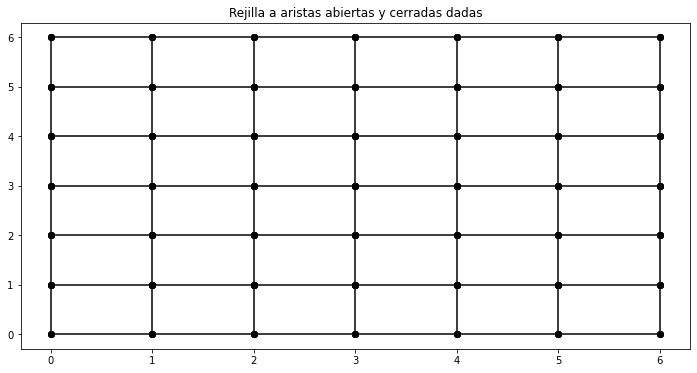

In [9]:
n = 3
l = 2*n+1
M_v = np.ones((l-1,l))
M_h = np.ones((l,l-1))
viendo_el_grafo(M_v, M_h, n,12, 6)

# ¿Que estoy haciendo?
Para entender un poco que estoy haciendo visualizaremos lo que estamos obteniendo usaremos la función anterior para graficar algunos resultados, la idea es comparar los métodos
- Metropolis_Hasting
- Metropolis_Hasting2
- Metropolis_Hasting3

todos los métodos se probarán con un valor inicial de "todos a la derecha", para esto primero, pondremos unos valores razonables para probar

In [12]:
n_0 = 25
N_0 = (2*n_0+1)**2
x_1 = todos_ordenados(n_0)
#beta = 25
beta = 1/np.sqrt(2*np.pi)
#beta = (0.07)**(-1)
a=8
b=6

## Resultados con Metropolis_Hasting_XY
A continuación veremos que da con la transición "propuesta"

In [13]:
%%time
XY_12 = Metropolis_Hasting_XY(N_0, n_0, x_1, beta)

CPU times: user 338 ms, sys: 4.39 ms, total: 342 ms
Wall time: 342 ms


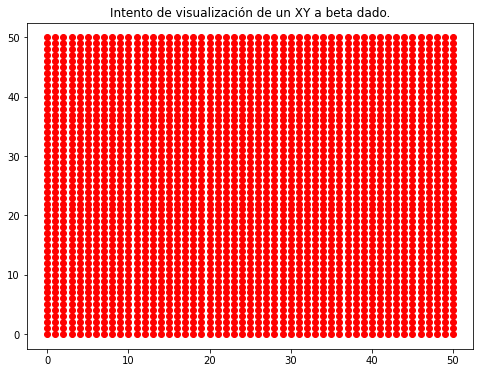

In [14]:
coloreando(x_1,n_0,a,b)

## Resultados con Metropolis_Hasting2_XY
A continuación veremos que da con la transición "propuesta_2"

In [15]:
%%time
XY_22 = Metropolis_Hasting2_XY(N_0, n_0, x_1, beta)

CPU times: user 312 ms, sys: 4.18 ms, total: 316 ms
Wall time: 314 ms


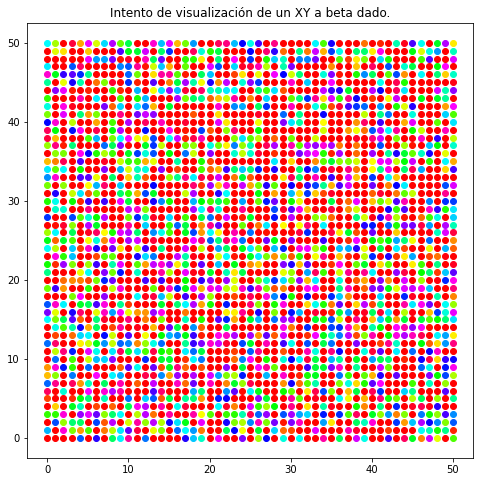

In [18]:
coloreando(XY_22,n_0,8,8)

## Resultados con Metropolis_Hasting3_XY
A continuación veremos que da con la transición "propuesta"

In [19]:
%%time
XY_3 = Metropolis_Hasting3_XY(n_0, x_1, beta)

CPU times: user 1.48 s, sys: 16.5 ms, total: 1.5 s
Wall time: 1.62 s


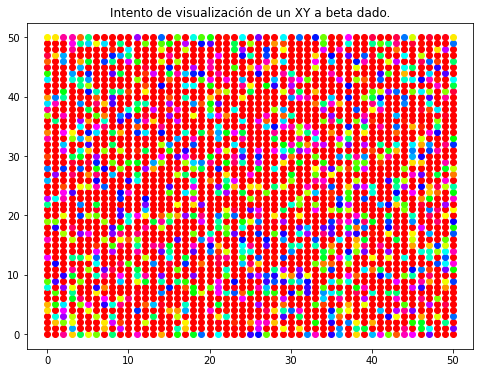

In [20]:
coloreando(XY_3,n_0,a,b)

# Algoritmo Swendsen-Wang
A continuación se implementará el código de Swedsen-wang (desde ahora S.W.) para el modelo XY para después comparar con los resultados de M.H.

Primero, puesto que tengo el pseudo-código a mano gracias al paper del profe, veremos como hacer S.W. en el modelo de Villain
La bibliografía se dara más adelante.

Después todo lo realizado se pasara a clase, preguntar a Gustavo.


## S.W. en Villain
Como ejemplo de juguete primero veamos el algoritmo S.W. para el modelo de Ising, pues es el más simple de implementar. Aquí los objetivos es ver
- como usar y mover la variable $d = (d_x)_{x\in E}$
- como relacionar lo anterior con las leyes marginales correspondientes
- que objeto usar para tratar con la variable aleatoria y la variable $d$

### Densidades a usar
Primero veamos las funciones que nos exige el algoritmo usar para ir declarando abierto o cerrado.

In [9]:
def Serie_LHS(x, t):
    S1 = np.array([-2,-1,0,1,2])
    return np.sqrt(t)*sum([np.exp(-1*t*np.pi*((x+n)**2)) for n in S1])

def Serie_RHS(x, t):
    S1 = np.array([1,2])
    return 1+2*sum([np.exp(-1*np.pi*(t**(-1))*(n**2))*np.cos(2*np.pi*n*x) for n in S1])

In [10]:
def f(x, beta):
    Tau = 2*np.pi*beta
    t = 1/beta
    if t<2*np.pi:
        return Serie_LHS(x/(2*np.pi), Tau)/np.sqrt(Tau)
    elif t>=2*np.pi:
        return  Serie_RHS(x/(2*np.pi),Tau)/np.sqrt(Tau)

#Tengo que reparar esto
def g(theta_1, theta_2, beta):
    x = theta_1-theta_2
    y = theta_1+theta_2-np.pi
    if f(x,beta).all() != 0:
        return (f(x,beta)-f(y,beta))/f(x, beta)
    else:
        return 1

Veamos un poco su comportamiento.

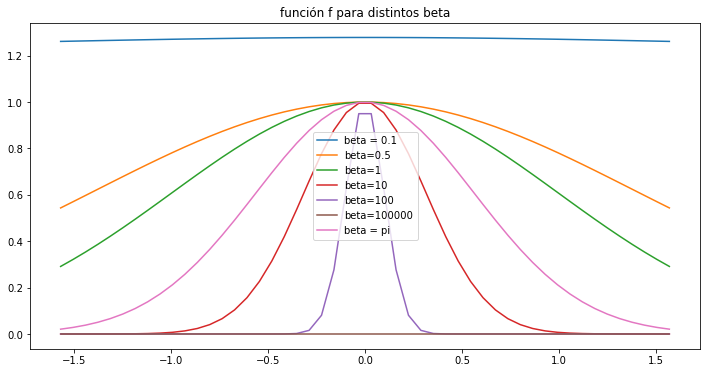

In [11]:
x=np.linspace((-1/2)*np.pi, (1/2)*np.pi)

plt.figure(figsize=(12,6))
plt.plot(x, f(x, beta= 0.1), label = "beta = 0.1")
plt.plot(x,f(x, beta=0.5),label = "beta=0.5")
plt.plot(x, f(x, beta=1),label = "beta=1")
plt.plot(x, f(x, beta=10),label = "beta=10")
plt.plot(x, f(x, beta=100),label = "beta=100")
plt.plot(x, f(x, beta=100000),label = "beta=100000")
plt.plot(x, f(x, beta=np.pi),label = "beta = pi")
plt.legend()
plt.title("función f para distintos beta")
plt.show()

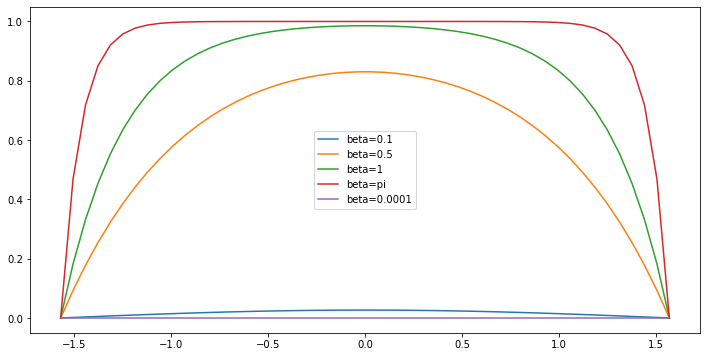

In [12]:
x=np.linspace((-1/2)*np.pi, (1/2)*np.pi)

plt.figure(figsize=(12,6))
plt.plot(x,g(x,0, beta=0.1),label = "beta=0.1")
plt.plot(x,g(x,0, beta=0.5),label = "beta=0.5")
plt.plot(x, g(x,0, beta=1),label = "beta=1")
plt.plot(x, g(x,0, beta=np.pi),label = "beta=pi")
plt.plot(x, g(x,0, beta=0.0001),label = "beta=0.0001")
plt.legend()
plt.show()

Asumiendo lo anterior no es tan risorio veamos como hariamos el resto del algoritmo, para ver si estan quedando cosas abiertas o no, usar viendo_el_grafo(), recordemos M_v es de lxl+1 y M_h es de l+1x1, una arista abierta es 1, una cerrada es -1

In [11]:
#La idea fuerte es ver la transición de un estado a otro usando los clusters, para esto codifiquemos primero
#lo que necesitamos de los clusters y después hacemos la transición
def cambio_eje(x,nu,n):
    l = 2*n+1
    y=np.copy(x)
    #R=rotacion(v)
    for i in range(l):
        for j in range(l):
            theta = color_hue_2(y[i,j,:])
            theta_R = theta+nu
            y[i,j,:] = np.array([np.cos(theta_R), np.sin(theta_R)])
    return y

#veamos las verticales
def Aristas_V(n,x_0,beta, nu):
    l=2*n
    M_v = np.zeros((l,l+1))
    for fila in range(l):
        for columna in range(l+1):
            u = np.random.uniform()
            theta_1= color_hue(x_0[fila, columna,:])
            theta_2= color_hue(x_0[fila+1, columna,:])
            if (np.cos(theta_1-nu)>0) and (np.cos(theta_2-nu)>0): # recuerda en el paper es -nu
                if u<g(theta_1-nu,theta_2-nu, beta):
                    M_v[fila, columna] = 1 #open
            if (np.cos(theta_1-nu)<0) and (np.cos(theta_2-nu)<0):
                if u<g(np.pi+(theta_1-nu),np.pi+(theta_2-nu), beta):
                    M_v[fila, columna] = 1 #open
    return M_v

def Aristas_H(n,x_0,beta,nu):
    l=2*n
    M_h = np.zeros((l+1,l))
    for fila in range(l+1):
        for columna in range(l):
            u2 = np.random.uniform()
            theta_1= color_hue(x_0[fila, columna,:])
            theta_2= color_hue(x_0[fila, columna+1,:])   # recuerda en el paper es -nu
            if (np.cos(theta_1-nu)>0) and (np.cos(theta_2-nu)>0):
                if u2<g(theta_1-nu,theta_2-nu, beta):
                    M_h[fila, columna] = 1 #open
            if (np.cos(theta_1-nu)<0) and (np.cos(theta_2-nu)<0):
                if u2<g(np.pi+(theta_1-nu),np.pi+(theta_2-nu), beta):
                    M_h[fila, columna] = 1 #open
    return M_h

In [49]:
2*np.pi% (1/2)*np.pi

0.889652880639957

Lo anterior nos da $d$ dividido segun la arista sea vertical u horizontal

## ¿Se puede hacer más rapido?

El algoritmo de abajo salio casi en su totalidad de  $$ chrome-extension://oemmndcbldboiebfnladdacbdfmadadm/https://math.hws.edu/eck/cs327_s04/chapter9.pdf$$

In [12]:
def vecinos(fila, columna, n, M_v, M_h):
    l =2*n+1 #notice that  l = |V|
    vecinos = []
    #columns
    if 0<columna<(l-1):                     #neighbors left or right
        if M_h[fila, columna] == 1:         #neighbor to the right
            vecinos.append((fila, columna+1))
        if M_h[fila, columna-1] == 1:     #neighbor to the left
            vecinos.append((fila, columna-1))
    elif columna == l-1:                    # neighbor only to the left
        if M_h[fila, columna-1] == 1:
            vecinos.append((fila, columna-1))
    elif columna == 0:                      #neighbr only to the right
        if M_h[fila, columna]== 1:
            vecinos.append((fila,columna+1))

    #rows
    if 0<fila<(l-1):                        #neighbors up or down
        if M_v[fila, columna] == 1:         #neighbor up
            vecinos.append((fila+1, columna))
        if M_v[fila-1, columna] == 1:     #neighbor down
            vecinos.append((fila-1, columna))
    elif fila == l-1:
        if M_v[fila-1, columna] == 1:       #neighbot only down
            vecinos.append((fila-1, columna))
    elif fila == 0:
        if M_v[fila, columna] ==1:           #neighbor only up
            vecinos.append((fila+1, columna))
    return vecinos

def connected_components(n, M_v,M_h):
    l = 2*n+1
    Visited = np.zeros((l,l)) #zero means the vertex (i,j) hasn't been visited
    Cc = []
    for fila in range(l):
        for columna in range(l):
            if Visited[fila,columna] == 0: #vertex not visited.
                cc = [(fila,columna)]
                Visited[fila,columna] = 1 #mark as visited
                q = [(fila,columna)]
                while q!=[]:
                    w = q[0]
                    q.remove(w)
                    chequeo = vecinos(w[0], w[1], n, M_v, M_h)
                    for k in chequeo:
                        if Visited[k] == 0:
                            q.append(k)
                            cc.append(k)
                            Visited[k] = 1
                Cc.append(cc) #esto hay que cambiarlo pues es musha memoria y poco iterable
    return Cc


In [13]:
# esta función me dice como roto el cluster deseado.
def Rotar(M_v,M_h, n):
    l = 2*n+1
    R = np.zeros((l,l))
    Cc = connected_components(n, M_v,M_h)
    for c in Cc:
        a = (-1)**(np.random.binomial(1, 0.5))
        for v in c:
            R[v] = a
    return R


Ahora tenemos los elementos necesarios para poder hacer S.W. en Villain (y con un pequeño cambio tambien Ising

In [14]:
# n es el radio de la grilla
# N es el número de repeticiones
# x_1 es el valor inicial
def Swendsen_Wang_Villain(N,x_0, n,beta):
    #l =2*n+1
    x = np.copy(x_0)
    CC = []
    while N!=0:
        nu = np.random.uniform(low=0, high=2*np.pi)
        x = cambio_eje(x,nu,n)
        M_h = Aristas_H(n,x,beta,nu)
        M_v = Aristas_V(n,x,beta,nu)
        D = Rotar(M_v, M_h, n)
        y = np.copy(x)
        CC.append((M_h,M_v,nu, y))
        x[:,:,0] = D*x[:,:,0]
        N = N-1
    return (x,CC)

## Valores de prueba
A continuación empezaremos a obtener valores para ver que esta saliendo :)

In [17]:
n_0 = 50
N_0 = n_0
x_0 = todos_ordenados(n_0)
#beta = 1/np.sqrt(2*np.pi)
beta_L = 0.02
beta_H = 100
#beta = 10
#beta=1000
#beta = (0.8816)**(-1)
print("Simularemos a betas iguales ", beta_H,"y", beta_L," y numero de iteraciones N_0 =", N_0)

Simularemos a betas iguales  100 y 0.02  y numero de iteraciones N_0 = 50


In [18]:
%%time
SW = Swendsen_Wang_Villain(N_0,x_0, n_0,beta_L)

CPU times: user 1min 4s, sys: 770 ms, total: 1min 4s
Wall time: 1min 5s


In [19]:
SW_V = SW[0]

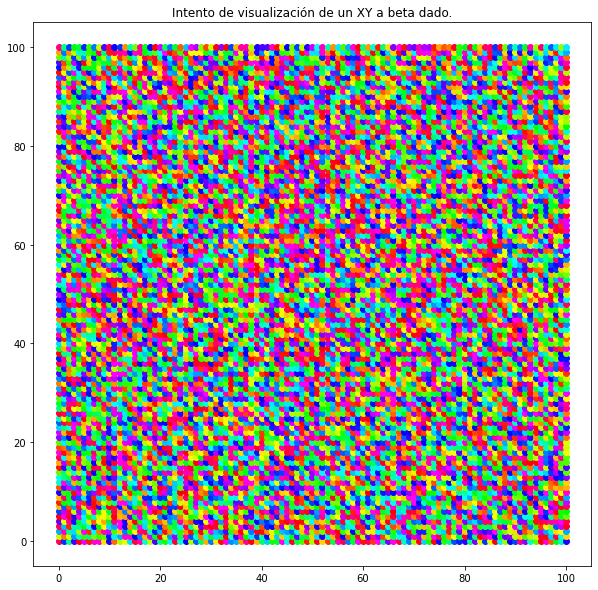

In [20]:
coloreando(SW_V,n_0,10,10)

In [21]:
%%time
SWC = Swendsen_Wang_Villain(N_0,x_0, n_0,beta_H)

CPU times: user 1min 3s, sys: 417 ms, total: 1min 3s
Wall time: 1min 4s


In [22]:
SWC_V = SWC[0]

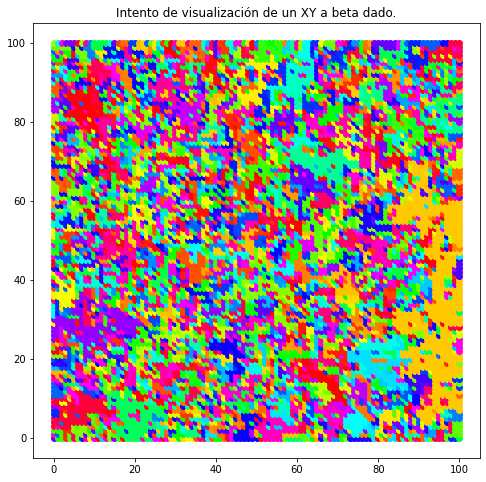

In [23]:
coloreando(SWC_V,n_0,8,8)

In [311]:
SWC2 = Swendsen_Wang_Villain(10,x_0, n_0,beta_H)

In [312]:
SWC_V2 = SWC2[0]

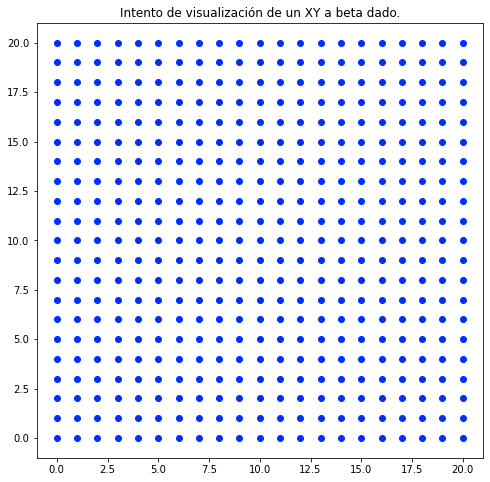

In [313]:
coloreando(SWC_V2,n_0,8,8)

In [238]:
CC=SWC[1]
for a in CC:
    M_h = a[0]
    M_v = a[1]
    if  len(connected_components(n_0, M_v,M_h)) != 1 :
        print("podria tener", np.cos(color_hue_2(a[3][0,0])-a[2]))
        print("el angulo de una esquina proyectado en x es",np.cos(color_hue_2(a[3][0,20])))
        print("podria tener", np.cos(color_hue_2(a[3][0,1])-a[2]))
        print("el angulo de una esquina proyectado en x es",np.cos(color_hue_2(a[3][1,20])))
        print("numero de componentes conexas", len(connected_components(n_0, M_v,M_h)))
        #viendo_el_grafo(M_v,M_h,n_0, 8,8)
    #print("los angulos de entrada en g estan o no en el buen intervalo",(1/2)*np.pi>color_hue_2(a[3][0,0])-a[2]>(-1/2)*np.pi)


podria tener -0.8213536513539097
el angulo de una esquina proyectado en x es -0.35337957841667483
podria tener -0.8213536513539097
el angulo de una esquina proyectado en x es -0.35337957841667483
numero de componentes conexas 16
podria tener 0.8608762472097011
el angulo de una esquina proyectado en x es -0.940990398573463
podria tener 0.6130205292262222
el angulo de una esquina proyectado en x es -0.45406495426231136
numero de componentes conexas 8
podria tener -0.8560666519255937
el angulo de una esquina proyectado en x es 0.9226622786707865
podria tener 0.7000509942733774
el angulo de una esquina proyectado en x es -0.797286591504135
numero de componentes conexas 8
podria tener -0.8989241447368369
el angulo de una esquina proyectado en x es -0.12756819966336563
podria tener -0.998710186434024
el angulo de una esquina proyectado en x es 0.36754462803439825
numero de componentes conexas 8
podria tener -0.51271517867662
el angulo de una esquina proyectado en x es 0.6815957683038164
podr

En lo anterior algo no me cuadra, con lo que realizaremos uno con un pequeño cambio y aparte veremos el caso de Ising

In [134]:
def Swendsen_Wang_Villain2(N,x_0, n,beta):
    l =2*n+1
    x = np.copy(x_0)
    Cc= []

    while N!=0:
        nu = np.random.uniform(low=0, high=2*np.pi)
        x= cambio_eje(x,nu,n)
        M_h = Aristas_H(n,x_0,beta,nu)
        M_v = Aristas_V(n,x_0,beta,nu)
        Cc.append((M_h,M_v,nu))
        D = Rotar(M_v, M_h, n)
        for fila in range(l):
            for columna in range(l):
                if D[fila, columna] == -1: #rotamos
                    theta = color_hue_2(x[fila, columna,:])
                    theta_R = 2*nu+np.pi-theta
                    x[fila, columna,:] = np.array([np.cos(theta_R), np.sin(theta_R)])
        N-=1
    return (x,Cc)

In [135]:
%%time
SW2 = Swendsen_Wang_Villain2(N_0,x_0, n_0,beta)

CPU times: user 46.4 s, sys: 258 ms, total: 46.6 s
Wall time: 46.6 s


In [107]:
SW2_V2 = SW2[0]

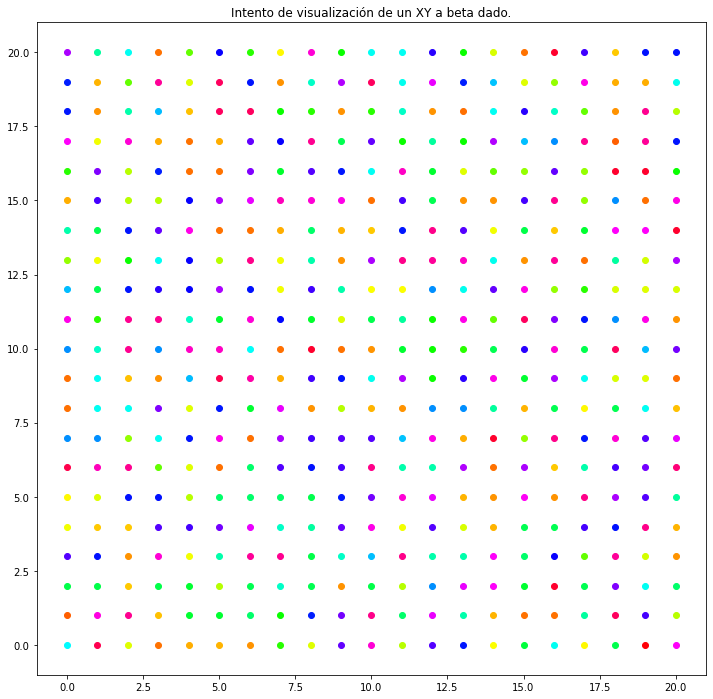

In [136]:
coloreando(SW2_V2,n_0,12,12)

In [275]:
CC2=SW2[1]
for a in CC:
    M_h = a[0]
    M_v = a[1]
    plt.legend(label=a[2])
    grafo = viendo_el_grafo(M_v, M_h, n_0,12,6)

IndexError: tuple index out of range

Ver el valor nu, ahi puede haber un problema